# Exploitation Comparison of Different Zero-sum Game Methods
The figures show the learning curve of the exploiter after the model is trained with different type of methods. The exploiter is set as the second player for all envs and methods.

In [2]:
import json
import os, re
import numpy as np

def load_data(file_name):
    file_dir = folder+file_name
    # print(file_dir)
    
    data = json.load( open(file_dir+"/eval.json"))
    # print(data.keys())
    return data

def smooth(y, radius=200, mode='two_sided'):
    if len(y) < 2*radius+1:
        return np.ones_like(y) * y.mean()
    elif mode == 'two_sided':
        convkernel = np.ones(2 * radius+1)
        return np.convolve(y, convkernel, mode='same') / \
                np.convolve(np.ones_like(y), convkernel, mode='same')
    elif mode == 'causal':
        convkernel = np.ones(radius)
        out = np.convolve(y, convkernel,mode='full') / \
                np.convolve(np.ones_like(y), convkernel, mode='full')
        return out[:-radius+1]

In [15]:
import os
import sys
import pandas as pd  
pd.set_option('display.max_rows', None)  # or 1000

envs = ['double_dunk', 'boxing', 'surround', 'pong', 'tennis', 'slimevolley']
indices = ['20220421_1855', '20220429_0152', '20220427_1507']

exploited_models = ['first', 'second']
times=  ['1', '2', '3']
results = [[[[[10 for _ in exploited_models] for _ in times] for _ in indices] for _ in range(7)] for _ in envs]
all_rewards = [[[[[[0] for _ in exploited_models] for _ in times] for _ in indices] for _ in range(7)] for _ in envs]
methods = ['fictitious_selfplay2', 'nash_dqn', 'nash_dqn_exploiter', 'nash_ppo', 'nfsp', 'nxdo2', 'selfplay2']

print(np.array(results).shape)
for m, index in enumerate(indices):
    for i, exploited_model in enumerate(exploited_models):
        for t in times:
            os.makedirs(f'{index}_exploit/{exploited_model}_{t}', exist_ok=True)
            folder = f'../data/log/{index}_exploit_{exploited_model}_{t}/'
            files = ! ls $folder
            # print(files)

            if exploited_model == 'first':
                agent_to_plot = 'second_0'  # 'first_0' or 'second_0'
            else:
                agent_to_plot = 'first_0'

            for j, env in enumerate(envs):
                env_files =[f for f in files if env in f]
                # print(env_files)
                # methods = []
                for _, f in enumerate(env_files):
                    data = load_data(f)
                    method = re.split('v(\d+)_', f)[-1] # split with 'v*'

                    v = smooth(data['episode_reward'][agent_to_plot], radius=50)

                    if method == 'nash_dqn_exploiter' and exploited_model == 'second': # this is invalid since only exploiting first side of nash_dqn_exploiter
                        max_exploiter_reward = 100 # large enough to not be taken
                    else:
                        max_exploiter_reward = max(v)  # max exploiter reward in smoothed evaluation curve
                    # print(env, method, agent_to_plot, max_exploiter_reward)
                    k = methods.index(method)  # some log can miss, use this give correct index
                    results[j][k][m][int(t)-1][i] = max_exploiter_reward  # env, method, indx, time, exploit_idx 
                    all_rewards[j][k][m][int(t)-1][i] = data['episode_reward']
                    episode = data['episode']

results = np.array(results)
print(results.shape)
idx1 = np.argmin(results, axis=-1)  # exploit_idx (which side of the exploited model)
results = np.min(results, axis=-1) # less exploitable one
track_results = results
print(results.shape)
idx2 = np.argmax(results, axis=-1)  # time (which time of the exploitation)
results = np.max(results, axis=-1) # most exploitable exploiter
print(results.shape)
idx3 = np.argmin(results, axis=-1)  # indx (which model is exploited)
results = np.min(results, axis=-1) # less exploitable model
print(results.shape, results)
print(idx1.shape, idx2.shape, idx3.shape)

ranges = 7*[10, 100, 3, 6, 6, 3]
ranges = np.array(ranges).reshape(7,6).T
norm_results = results/ranges

results_dict = {}
norm_results_dict = {}

for k, method in enumerate(methods):
    results_dict[method] = results[:, k]
    norm_results_dict[method] = norm_results[:, k]

df = pd.DataFrame(results_dict, index=envs)
print('results: \n', df)

norm_df = pd.DataFrame(norm_results_dict, index=envs)
print('normlized results: \n', norm_df)

(6, 7, 3, 3, 2)
(6, 7, 3, 3, 2)
(6, 7, 3, 3)
(6, 7, 3)
(6, 7) [[ 6.06779661e+00 -5.39473684e-01  1.70297030e+00 -2.37623762e-01
   4.56435644e+00  7.25641026e+00  7.03960396e+00]
 [ 9.36831683e+01 -5.54714286e+01  2.24901961e+01  7.96071429e+01
   2.45441176e+01  6.68910891e+01  2.49076923e+01]
 [ 1.57425743e+00  9.04255319e-01  1.46296296e+00  4.65346535e-01
   1.59405941e+00  1.60396040e+00  1.78217822e+00]
 [ 5.19607843e+00 -3.33663366e+00 -2.92079208e+00 -1.38613861e-01
   4.39603960e+00  5.21782178e+00  4.20792079e+00]
 [ 2.35593220e+00 -4.25742574e-01  6.93069307e-02 -1.49504950e+00
   3.20792079e+00  2.46534653e+00  2.97029703e+00]
 [ 5.14851485e-01  0.00000000e+00 -9.90099010e-02 -8.80952381e-01
   6.93069307e-02  0.00000000e+00 -4.95049505e-02]]
(6, 7, 3, 3) (6, 7, 3) (6, 7)
results: 
              fictitious_selfplay2   nash_dqn  nash_dqn_exploiter   nash_ppo  \
double_dunk              6.067797  -0.539474            1.702970  -0.237624   
boxing                  93.683168 -5

In [119]:
# means and stds
track_results = np.array(track_results).reshape(track_results.shape[0], track_results.shape[1], -1)
means = np.mean(track_results, axis=-1)
stds = np.std(track_results, axis=-1)
means_dict, stds_dict = {}, {}
for k, method in enumerate(methods):
    means_dict[method] = means[:, k]
    stds_dict[method] = stds[:, k]
mean = pd.DataFrame(means_dict, index=envs)
print(mean)
std = pd.DataFrame(stds_dict, index=envs)
print(std)

             fictitious_selfplay2   nash_dqn  nash_dqn_exploiter   nash_ppo  \
double_dunk              6.314382   0.024767            1.678715  -0.054725   
boxing                  88.068667 -67.411323           19.789637  79.215419   
surround                 1.642080   1.028377            1.299616   0.464873   
pong                     5.018895  -2.016049           -1.758343   1.431872   
tennis                   2.950003  -0.418466            2.622392  -0.318559   
slimevolley              0.620462   0.513751           -0.148515  -0.870185   

                  nfsp      nxdo2  selfplay2  
double_dunk   3.873509   8.087113   7.537285  
boxing       34.107490  81.078099  46.929688  
surround      1.721356   1.665428   1.566543  
pong          4.341843   5.170577   4.876515  
tennis        3.579641   2.793491   3.772605  
slimevolley   0.379538   3.490070   0.155116  
             fictitious_selfplay2   nash_dqn  nash_dqn_exploiter   nash_ppo  \
double_dunk              0.800506   0.

In [16]:
!pip install seaborn
import matplotlib.pyplot as plt
import numpy as np
# plt.rcParams['savefig.facecolor']='white'
# plt.style.use('seaborn-whitegrid')
# plt.style.use('default')
import seaborn as sns
sns.set_theme()
import matplotlib.cm as cm



In [17]:
def plot(x, data, method, color, agent_to_plot, order, smooth_radius=200, range=100000):
    def smooth(y, radius=200, mode='two_sided'):
        if len(y) < 2*radius+1:
            return np.ones_like(y) * y.mean()
        elif mode == 'two_sided':
            convkernel = np.ones(2 * radius+1)
            return np.convolve(y, convkernel, mode='same') / \
                   np.convolve(np.ones_like(y), convkernel, mode='same')
        elif mode == 'causal':
            convkernel = np.ones(radius)
            out = np.convolve(y, convkernel,mode='full') / \
                  np.convolve(np.ones_like(y), convkernel, mode='full')
            return out[:-radius+1]

    k = method
    v = data[agent_to_plot]
    try:
        plt.plot(x, v[:range], color=color, alpha=0.1, zorder=1)
        plt.plot(x, smooth(v[:range], radius=smooth_radius), color=color, label=k, zorder=order)
    except:
        pass


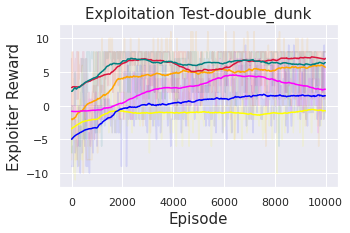

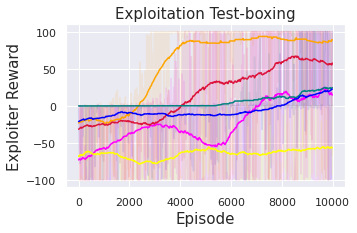

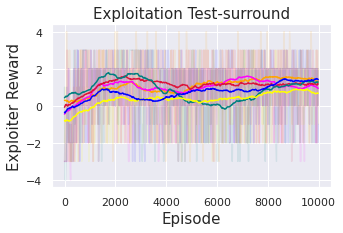

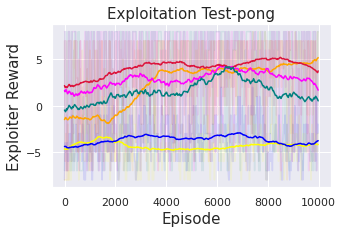

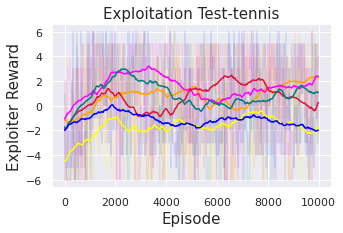

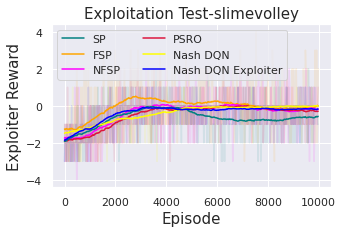

In [19]:
colors = cm.rainbow(np.linspace(0, 1, 7))
#https://matplotlib.org/3.1.0/tutorials/colors/colors.html
colors = ['orange', 'yellow',   'blue', 'black','fuchsia', 'crimson', 'teal',]
os.makedirs(f'selected_exploit', exist_ok=True)

skip_methods = ['nash_ppo']
highlight_methods = ['nash_dqn', 'nash_dqn_exploiter']

labels = {'nash_dqn': 'Nash DQN', 
        'nash_dqn_exploiter': 'Nash DQN Exploiter', 
        'selfplay2': 'SP', 
        'fictitious_selfplay2': 'FSP', 
        'nxdo2': 'PSRO', 
        'nfsp': 'NFSP', 
        'nash_ppo': 'Nash PPO', 

}

for env, idx1_env, idx2_env, idx3_env, rewards_env in zip(envs, idx1, idx2, idx3, all_rewards):
    plt.figure(figsize=(5, 3))
    plt.clf()
    for method, idx1_env_m, idx2_env_m, idx3_env_m, rewards_env_m, c in zip(methods, idx1_env, idx2_env, idx3_env, rewards_env, colors):

        if method in skip_methods:
            continue

        if method in highlight_methods:
            order = 3
        else:
            order = 2
        
        index = indices[idx3_env_m]
        t = idx2_env_m[idx3_env_m]
        exploit_idx = idx1_env_m[idx3_env_m][t]
        time = t + 1

        if exploit_idx == 0:
            exploited_model = 'first'
        else:
            exploited_model = 'second'

        folder = f'../data/log/{index}_exploit_{exploited_model}_{time}/'
        # print(folder)
        files = ! ls $folder       
        
        if exploited_model == 'first':
            agent_to_plot = 'second_0'  # 'first_0' or 'second_0'
        else:
            agent_to_plot = 'first_0'
        # print(np.array(rewards_env_m).shape, idx3_env_m, t, exploit_idx)
        episode_reward = rewards_env_m[idx3_env_m][t][exploit_idx]
        
        for f in files:
            if env in f and method in f:
                if method == 'nash_dqn_exploiter': # only take the exploitation of first player 
                    plot(episode, episode_reward, labels[method], c, 'second_0', order, smooth_radius=50)
                else:
                    plot(episode, episode_reward, labels[method], c, agent_to_plot, order, smooth_radius=50)
                break

    if env == 'slimevolley':
        # re-order the legend
        handles, ls = plt.gca().get_legend_handles_labels()
        # print(ls)
        new_order = [5,0,3,4,1,2]
        plt.legend([handles[i] for i in new_order],[ls[i] for i in new_order], loc=2, ncol=2)
        # plt.legend(loc=2)

    # plt.grid()
    plt.title(f'Exploitation Test-{env}', fontsize= 15)
    plt.xlabel('Episode', fontsize= 15)
    plt.ylabel('Exploiter Reward', fontsize= 15)
    savepath=f'selected_exploit/compare_exploitation_{env}.png'
    plt.savefig(savepath, bbox_inches='tight', dpi=300)



In [6]:
# results for full length env
import os
import sys
import pandas as pd  
pd.set_option('display.max_rows', None)  # or 1000

envs = ['boxing']
indices = ['20220508_1730']

exploited_models = ['first', 'second']
times=  ['1', '2', '3']
results = [[[[[10 for _ in exploited_models] for _ in times] for _ in indices] for _ in range(7)] for _ in envs]
all_rewards = [[[[[[0] for _ in exploited_models] for _ in times] for _ in indices] for _ in range(7)] for _ in envs]
methods = ['fictitious_selfplay2', 'nash_dqn', 'nash_dqn_exploiter', 'nash_ppo', 'nfsp', 'nxdo2', 'selfplay2']

print(np.array(results).shape)
for m, index in enumerate(indices):
    for i, exploited_model in enumerate(exploited_models):
        for t in times:
            os.makedirs(f'{index}_exploit/{exploited_model}_{t}', exist_ok=True)
            folder = f'../data/log/{index}_exploit_{exploited_model}_{t}/'
            files = ! ls $folder
            # print(files)

            if exploited_model == 'first':
                agent_to_plot = 'second_0'  # 'first_0' or 'second_0'
            else:
                agent_to_plot = 'first_0'

            for j, env in enumerate(envs):
                env_files =[f for f in files if env in f]
                # print(env_files)
                # methods = []
                for _, f in enumerate(env_files):
                    data = load_data(f)
                    method = re.split('v(\d+)_', f)[-1] # split with 'v*'

                    v = smooth(data['episode_reward'][agent_to_plot], radius=50)

                    if method == 'nash_dqn_exploiter' and exploited_model == 'second': # this is invalid since only exploiting first side of nash_dqn_exploiter
                        max_exploiter_reward = 100 # large enough to not be taken
                    else:
                        max_exploiter_reward = max(v)  # max exploiter reward in smoothed evaluation curve
                    # print(env, method, agent_to_plot, max_exploiter_reward)
                    k = methods.index(method)  # some log can miss, use this give correct index
                    results[j][k][m][int(t)-1][i] = max_exploiter_reward  # env, method, indx, time, exploit_idx 
                    all_rewards[j][k][m][int(t)-1][i] = data['episode_reward']
                    episode = data['episode']

results = np.array(results)
print(results.shape)
idx1 = np.argmin(results, axis=-1)  # exploit_idx (which side of the exploited model)
results = np.min(results, axis=-1) # less exploitable one
track_results = results
print(results.shape)
idx2 = np.argmax(results, axis=-1)  # time (which time of the exploitation)
results = np.max(results, axis=-1) # most exploitable exploiter
print(results.shape)
idx3 = np.argmin(results, axis=-1)  # indx (which model is exploited)
results = np.min(results, axis=-1) # less exploitable model
print(results.shape, results)
print(idx1.shape, idx2.shape, idx3.shape)


results_dict = {}
for k, method in enumerate(methods):
    results_dict[method] = results[:, k]
df = pd.DataFrame(results_dict, index=envs)
print(df)

(1, 7, 1, 3, 2)
(1, 7, 1, 3, 2)
(1, 7, 1, 3)
(1, 7, 1)
(1, 7) [[ 94.71287129 -49.17741935  31.77227723  99.91089109  57.45544554
   99.97029703  99.92156863]]
(1, 7, 1, 3) (1, 7, 1) (1, 7)
        fictitious_selfplay2   nash_dqn  nash_dqn_exploiter   nash_ppo  \
boxing             94.712871 -49.177419           31.772277  99.910891   

             nfsp      nxdo2  selfplay2  
boxing  57.455446  99.970297  99.921569  


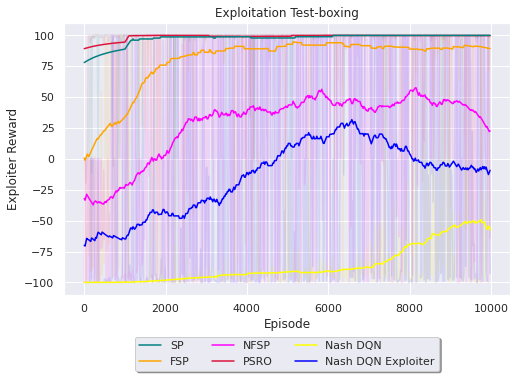

In [13]:
colors = cm.rainbow(np.linspace(0, 1, 7))
#https://matplotlib.org/3.1.0/tutorials/colors/colors.html
colors = ['orange', 'yellow',   'blue', 'black','fuchsia', 'crimson', 'teal',]
os.makedirs(f'selected_exploit', exist_ok=True)

skip_methods = ['nash_ppo']
highlight_methods = ['nash_dqn', 'nash_dqn_exploiter']

labels = {'nash_dqn': 'Nash DQN', 
        'nash_dqn_exploiter': 'Nash DQN Exploiter', 
        'selfplay2': 'SP', 
        'fictitious_selfplay2': 'FSP', 
        'nxdo2': 'PSRO', 
        'nfsp': 'NFSP', 
        'nash_ppo': 'Nash PPO', 

}

for env, idx1_env, idx2_env, idx3_env, rewards_env in zip(envs, idx1, idx2, idx3, all_rewards):
    plt.figure(figsize=(8, 5))
    plt.clf()
    for method, idx1_env_m, idx2_env_m, idx3_env_m, rewards_env_m, c in zip(methods, idx1_env, idx2_env, idx3_env, rewards_env, colors):

        if method in skip_methods:
            continue

        if method in highlight_methods:
            order = 3
        else:
            order = 2
        
        index = indices[idx3_env_m]
        t = idx2_env_m[idx3_env_m]
        exploit_idx = idx1_env_m[idx3_env_m][t]
        time = t + 1

        if exploit_idx == 0:
            exploited_model = 'first'
        else:
            exploited_model = 'second'

        folder = f'../data/log/{index}_exploit_{exploited_model}_{time}/'
        # print(folder)
        files = ! ls $folder       
        
        if exploited_model == 'first':
            agent_to_plot = 'second_0'  # 'first_0' or 'second_0'
        else:
            agent_to_plot = 'first_0'
        # print(np.array(rewards_env_m).shape, idx3_env_m, t, exploit_idx)
        episode_reward = rewards_env_m[idx3_env_m][t][exploit_idx]
        
        for f in files:
            if env in f and method in f:
                if method == 'nash_dqn_exploiter':
                    plot(episode, episode_reward, labels[method], c, 'second_0', order, smooth_radius=50)
                else:
                    plot(episode, episode_reward, labels[method], c, agent_to_plot, order, smooth_radius=50)
                break

    # re-order the legend
    handles, ls = plt.gca().get_legend_handles_labels()
    new_order = [5,0,3,4,1,2]
    plt.legend([handles[i] for i in new_order],[ls[i] for i in new_order],\
        loc='lower center', bbox_to_anchor=(0.5, -0.3),
        ncol=3, fancybox=True, shadow=True)
    # plt.grid()
    plt.title(f'Exploitation Test-{env}')
    plt.xlabel('Episode')
    plt.ylabel('Exploiter Reward')
    savepath=f'selected_exploit/compare_exploitation_{env}_full_length.png'
    plt.savefig(savepath, bbox_inches='tight', dpi=300)

